# Figures

## SODA

In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import fsspec
import xmitgcm
from xhistogram.xarray import histogram
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
%matplotlib inline
from fastjmd95 import jmd95numba
import json

In [2]:
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [8]:
wmt_budget_terms_unsliced = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/SODA/datasets/wmt_budget_terms/wmt_budget_terms.zarr'))
wmt_budget_terms_unsliced#.load()

<xarray.Dataset>
Dimensions:         (time: 985, sigma2_bin: 699)
Coordinates:
  * sigma2_bin      (sigma2_bin) float64 1.032e+03 1.032e+03 ... 1.039e+03
  * time            (time) object 1993-01-07 01:00:00 ... 2019-12-17 01:00:00
Data variables:
    dVdt            (time, sigma2_bin) float64 dask.array<chunksize=(247, 175), meta=np.ndarray>
    omega_trans     (time, sigma2_bin) float64 dask.array<chunksize=(247, 175), meta=np.ndarray>
    psi_vel         (time, sigma2_bin) float32 dask.array<chunksize=(247, 350), meta=np.ndarray>
    u_binned_left   (time, sigma2_bin) float32 dask.array<chunksize=(247, 350), meta=np.ndarray>
    u_binned_right  (time, sigma2_bin) float32 dask.array<chunksize=(247, 350), meta=np.ndarray>
    v_binned        (time, sigma2_bin) float32 dask.array<chunksize=(247, 350), meta=np.ndarray>

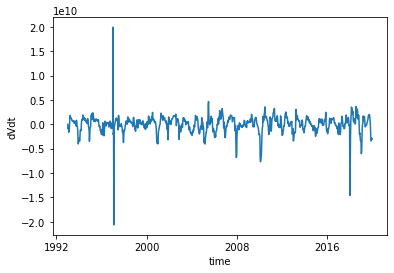

In [9]:
#spike caused by jump in salinity from nudging
wmt_budget_terms_unsliced.dVdt.sum('sigma2_bin').plot()

In [10]:
#Converting time from Julian to datetime64[ns] object
datetimeindex = wmt_budget_terms_unsliced.indexes['time'].to_datetimeindex()
wmt_budget_terms_unsliced['time'] = datetimeindex

/tmp/ipykernel_346/1132041841.py:2: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = wmt_budget_terms_unsliced.indexes['time'].to_datetimeindex()


In [58]:
wmt_budget_terms = wmt_budget_terms_unsliced.sel(time=slice('1997-02-15', '2019'))

In [59]:
wmt_budget_terms.load()

<xarray.Dataset>
Dimensions:         (time: 835, sigma2_bin: 699)
Coordinates:
  * sigma2_bin      (sigma2_bin) float64 1.032e+03 1.032e+03 ... 1.039e+03
  * time            (time) datetime64[ns] 1997-02-15T01:00:00 ... 2019-12-17T...
Data variables:
    dVdt            (time, sigma2_bin) float64 2.083e-05 2.083e-05 ... 0.0 0.0
    omega_trans     (time, sigma2_bin) float64 0.03028 0.03028 ... 0.0 0.0
    psi_vel         (time, sigma2_bin) float32 -0.03028 -0.03028 ... -0.0 -0.0
    u_binned_left   (time, sigma2_bin) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    u_binned_right  (time, sigma2_bin) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    v_binned        (time, sigma2_bin) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

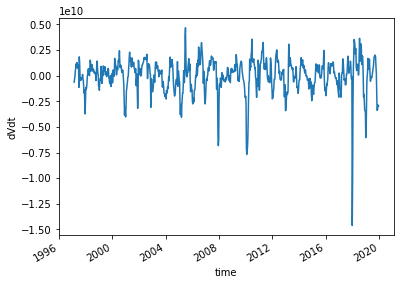

In [60]:
#spike caused by jump in salinity from nudging
wmt_budget_terms.dVdt.sum('sigma2_bin').plot()

## Time mean budgets

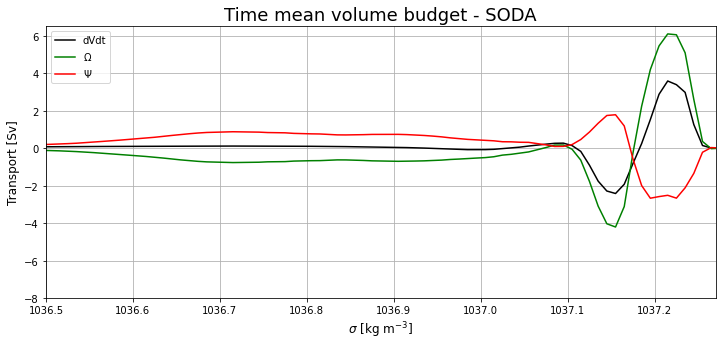

In [61]:
plt.figure(figsize=(12,5))
(wmt_budget_terms.dVdt/1e6).mean(dim='time').plot(label='dVdt', color='k')
wmt_budget_terms.omega_trans.mean(dim='time').plot(label=r'$\Omega$', color='green')
wmt_budget_terms.psi_vel.mean(dim='time').plot(label=r'$\Psi$', color='red')
plt.grid()
plt.legend()
plt.ylim(-8,6.5)
plt.xlim(1036.5, 1037.27)
plt.xlabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12)
plt.ylabel(r'Transport [Sv]', fontsize=12)
#plt.title(r'WMT volume budget in $\sigma$ space', fontsize=18);
plt.title('Time mean volume budget - SODA', fontsize=18);

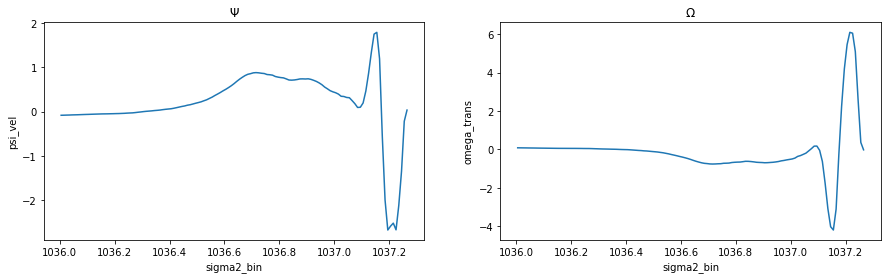

In [62]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(15,4))
wmt_budget_terms.psi_vel.mean('time').sel(sigma2_bin=slice(1036.0, 1037.27)).plot(ax=ax0)
wmt_budget_terms.omega_trans.mean('time').sel(sigma2_bin=slice(1036.0, 1037.27)).plot(ax=ax1)
ax0.set_title(r'$\Psi$')
ax1.set_title(r'$\Omega$');

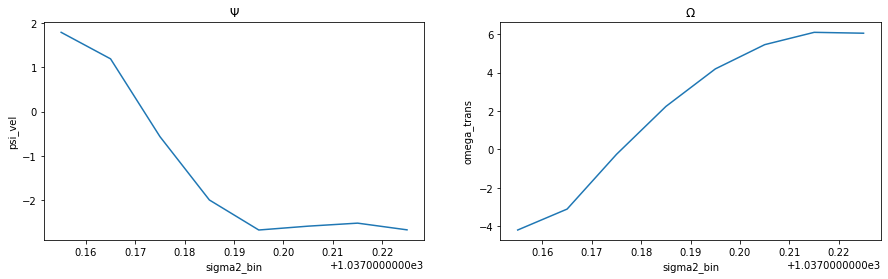

In [63]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(15,4))
wmt_budget_terms.psi_vel.mean('time').sel(sigma2_bin=slice(1037.15, 1037.23)).plot(ax=ax0)
wmt_budget_terms.omega_trans.mean('time').sel(sigma2_bin=slice(1037.15, 1037.23)).plot(ax=ax1)
ax0.set_title(r'$\Psi$')
ax1.set_title(r'$\Omega$');

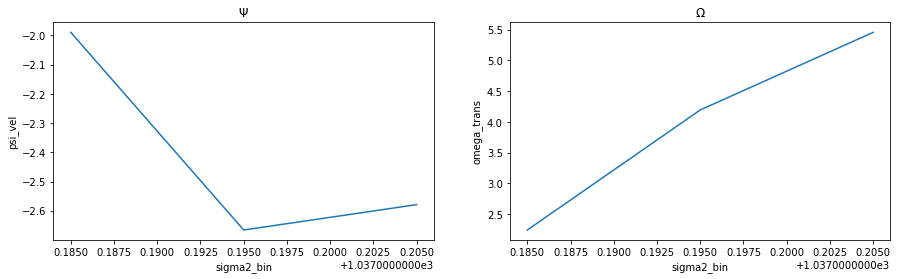

In [64]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(15,4))
wmt_budget_terms.psi_vel.mean('time').sel(sigma2_bin=slice(1037.18, 1037.21)).plot(ax=ax0)
wmt_budget_terms.omega_trans.mean('time').sel(sigma2_bin=slice(1037.18, 1037.21)).plot(ax=ax1)
ax0.set_title(r'$\Psi$')
ax1.set_title(r'$\Omega$');

### $\frac{\partial V}{\partial t}$

In [65]:
bottom = (wmt_budget_terms.mean('time').isel(sigma2_bin=-1) - 
          wmt_budget_terms.mean('time').sel(sigma2_bin=1037.195, method='nearest'))
deep = (wmt_budget_terms.mean('time').sel(sigma2_bin=1037.195, method='nearest') - 
        wmt_budget_terms.mean('time').isel(sigma2_bin=0))

In [66]:
print('BOTTOM dvdt:', bottom.dVdt.values/1e6, ' psi:', bottom.psi_vel.values, ' omega:', bottom.omega_trans.values)

BOTTOM dvdt: -1.527429964367664  psi: 2.6659498  omega: -4.1933794760027565


In [67]:
print('DEEP dvdt:', deep.dVdt.values/1e6, ' psi:', deep.psi_vel.values, ' omega:', deep.omega_trans.values)

DEEP dvdt: 1.5274299643676477  psi: -2.5731635  omega: 4.100593320370304


__SWITCH SIGN OF ALL TERMS__

* $\frac{\partial V}{\partial t}$ is (+ to -) for bottom wm, (- to +) for deep wm
   * (No longer cumulative volume!) Decreasing rate of volume means less water in wm; conversely, increasing rate of volume means more water in wm.
* $\Psi$ is (+ to -) for bottom wm, (- to +) for deep wm
   * Negative $\Psi$ means OUTflow, positive $\Psi$ means INflow
* $\Omega$ is (- to +) for bottom wm, (+ to -) for deep wm
   * using only one $\Omega$ (on the boundary) yields a positive value, which means positive transformation of deep layer water being added to bottom layer. (+) into layer 2 (bottom) is trying to add volume, (-) from layer 1 (deep) is trying to remove volume.

In [68]:
bottom = -bottom
deep = -deep

In [69]:
print('BOTTOM correct dvdt:', bottom.dVdt.values/1e6, ' correct psi:', bottom.psi_vel.values, ' correct omega:', bottom.omega_trans.values)

BOTTOM correct dvdt: 1.527429964367664  correct psi: -2.6659498  correct omega: 4.1933794760027565


In [70]:
print('DEEP correct dvdt:', deep.dVdt.values/1e6, ' correct psi:', deep.psi_vel.values, ' correct omega:', deep.omega_trans.values)

DEEP correct dvdt: -1.5274299643676477  correct psi: 2.5731635  correct omega: -4.100593320370304


### $\Psi$

In [71]:
bottom.psi_vel + deep.psi_vel

<xarray.DataArray 'psi_vel' ()>
array(-0.09278631, dtype=float32)

In [72]:
bottom.psi_vel

<xarray.DataArray 'psi_vel' ()>
array(-2.6659498, dtype=float32)

### $\Omega$

In [73]:
bottom.omega_trans + deep.omega_trans

<xarray.DataArray 'omega_trans' ()>
array(0.09278616)

In [74]:
bottom.omega_trans

<xarray.DataArray 'omega_trans' ()>
array(4.19337948)

In [75]:
omega_bdy = wmt_budget_terms.omega_trans.sel(sigma2_bin=1037.195, method='nearest')

In [76]:
omega_bdy_mean = omega_bdy.mean('time').load()

In [77]:
omega_bdy_mean

<xarray.DataArray 'omega_trans' ()>
array(4.19337948)
Coordinates:
    sigma2_bin  float64 1.037e+03

### Budget

In [78]:
-(bottom.dVdt/1e6) + bottom.psi_vel + bottom.omega_trans

<xarray.DataArray ()>
array(-3.09837076e-07)

In [79]:
-(bottom.dVdt/1e6) + bottom.psi_vel + omega_bdy_mean

<xarray.DataArray ()>
array(-3.09837079e-07)
Coordinates:
    sigma2_bin  float64 1.037e+03

In [80]:
-(deep.dVdt/1e6) + deep.psi_vel + deep.omega_trans

<xarray.DataArray ()>
array(1.5336624e-07)

In [81]:
-(deep.dVdt/1e6) + deep.psi_vel - omega_bdy_mean

<xarray.DataArray ()>
array(-0.092786)
Coordinates:
    sigma2_bin  float64 1.037e+03

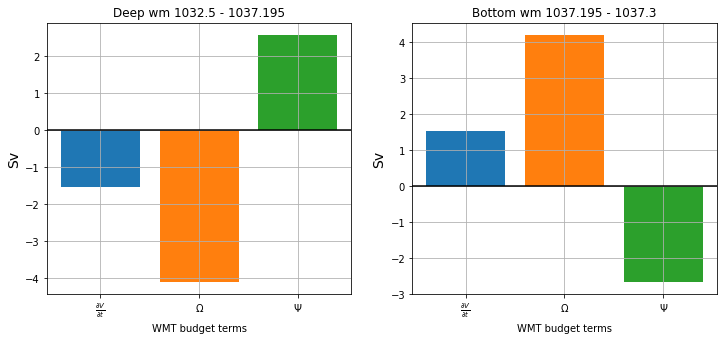

In [82]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,5))

ax0.bar(x=r'$\frac{\partial V}{\partial t}$', height = deep.dVdt/1e6)
ax0.bar(x=r'$\Omega$', height = deep.omega_trans)
ax0.bar(x=r'$\Psi$', height= deep.psi_vel)
ax0.axhline(y=0, color='k')
ax0.set_title('Deep wm 1032.5 - 1037.195')
ax0.set_ylabel('Sv', fontsize=14)
ax0.set_xlabel('WMT budget terms')
ax0.grid()
#ax0.set_ylim(-0.03, -0.1)

ax1.bar(x=r'$\frac{\partial V}{\partial t}$', height = bottom.dVdt/1e6)
ax1.bar(x=r'$\Omega$', height = bottom.omega_trans)
ax1.bar(x=r'$\Psi$', height= bottom.psi_vel)
ax1.axhline(y=0, color='k')
ax1.set_title('Bottom wm 1037.195 - 1037.3')
ax1.set_ylabel('Sv', fontsize=14)
ax1.set_xlabel('WMT budget terms')
ax1.grid()
#ax1.set_ylim(-0.1, 0.1);

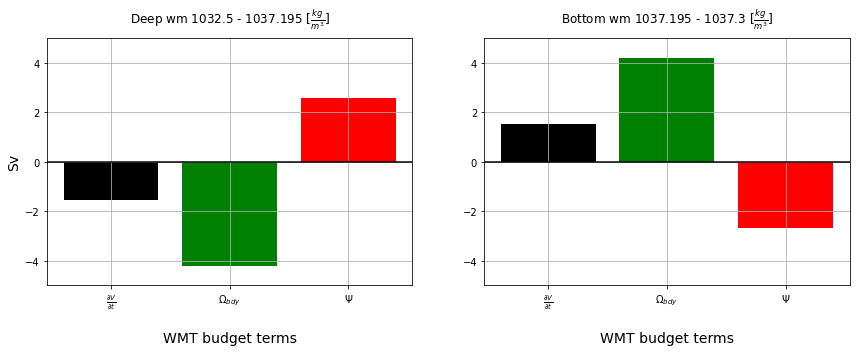

In [84]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,5))

ax0.bar(x=r'$\frac{\partial V}{\partial t}$', height = deep.dVdt/1e6, color='k')
ax0.bar(x=r'$\Omega_{bdy}$', height = - omega_bdy_mean, color='green')
ax0.bar(x=r'$\Psi$', height= deep.psi_vel, color='red')
ax0.axhline(y=0, color='k')
ax0.set_title(r'Deep wm 1032.5 - 1037.195 [$\frac{kg}{m^3}$]', pad=15)
ax0.set_ylabel('Sv', fontsize=14)
ax0.set_xlabel('WMT budget terms', fontsize=14, labelpad=20)
ax0.grid()
ax0.set_ylim(-5,5)

ax1.bar(x=r'$\frac{\partial V}{\partial t}$', height = bottom.dVdt/1e6, color='k')
ax1.bar(x=r'$\Omega_{bdy}$', height = omega_bdy_mean, color='green')
ax1.bar(x=r'$\Psi$', height= bottom.psi_vel, color='red')
ax1.axhline(y=0, color='k')
ax1.set_title(r'Bottom wm 1037.195 - 1037.3 [$\frac{kg}{m^3}$]', pad=15)
#ax1.set_ylabel('Sv', fontsize=14)
ax1.set_xlabel('WMT budget terms', fontsize=14, labelpad=20)
ax1.grid()
ax1.set_ylim(-5,5)

plt.tight_layout(w_pad=5);

> DEEP: Inflow, transformation is stronger and is making wm lose volume on avg. Net vol loss - not consistent with `wmt-budget-sigma-space-cleaned.ipynb`. CHECK AGAIN, RYAN SHOWED A DIFF CALCULATION FOR VOL GAIN/LOSS IN ECCO OR SOSE NB (1.27.21)

> BOTTOM: Outflow not as strong as positive transformation adding volume to wm. Net vol gain - not consistent with `wmt-budget-sigma-space-cleaned.ipynb` which shows net loss

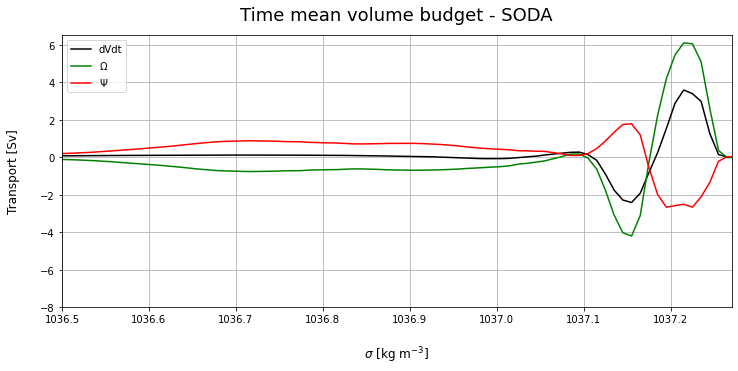

In [83]:
plt.figure(figsize=(12,5))
(wmt_budget_terms.dVdt/1e6).mean(dim='time').plot(label='dVdt', color='k')
wmt_budget_terms.omega_trans.mean(dim='time').plot(label=r'$\Omega$', color='green')
wmt_budget_terms.psi_vel.mean(dim='time').plot(label=r'$\Psi$', color='red')
plt.grid()
plt.legend()
plt.ylim(-8,6.5)
plt.xlim(1036.5, 1037.27)
plt.xlabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12, labelpad=20)
plt.ylabel(r'Transport [Sv]', fontsize=12, labelpad=20)
#plt.title(r'WMT volume budget in $\sigma$ space', fontsize=18);
plt.title('Time mean volume budget - SODA', fontsize=18, pad=15);

## Monthly Climatology

## BOTTOM Monthly Climatology

In [85]:
def anomaly(da):
    clim = da.groupby('time.month').mean(dim='time')
    anom = da.groupby('time.month') - clim
    #anom_chunk = anom.chunk({'time':-1, 'sigma2_bin':-1})
    anom_rolled = anom.rolling(time=36).mean(dim='time') #annual rolling mean to remove seasonal cycle
    return anom_rolled

In [86]:
#1037.185 to include 1037.195 when slicing
anom_ds = (wmt_budget_terms.sel(sigma2_bin=slice(1037.185, 1039)))

In [87]:
def clim(da):
    clim = da.groupby('time.month').mean(dim='time')
    #anom_rolled = anom.rolling(time=12).mean(dim='time')
    return clim

In [88]:
clim_ds = anom_ds

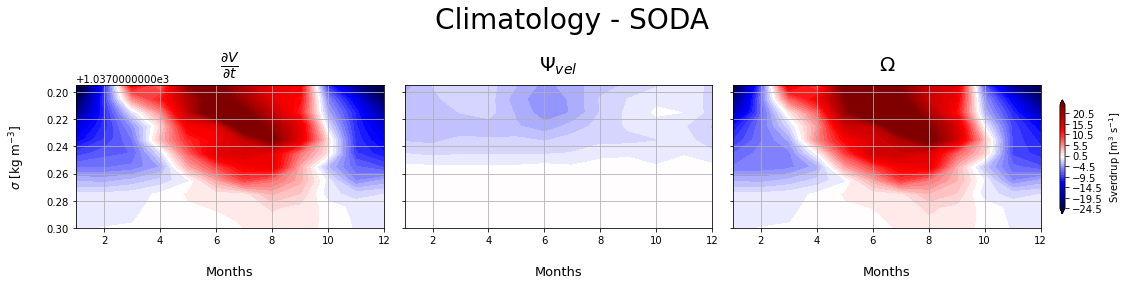

In [89]:
fig, (ax0,ax1,ax2) = plt.subplots(1, 3, figsize=(16, 4), sharey=True, gridspec_kw={'width_ratios': [2.4,2.4,3]})

levels = np.arange(-25, 25) + 0.5

dVdt_clim = clim(clim_ds.dVdt) / 1e6
c = ax0.contourf(dVdt_clim.month, 
                   dVdt_clim.sigma2_bin, 
                   dVdt_clim.T, cmap='seismic', levels=levels, extend='both')
#plt.colorbar(c, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax0)
ax0.set_ylabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12, labelpad=20)
#ax[0,0].set_xlabel('Time', fontsize=14)
ax0.set_title(r'$\frac{\partial V}{\partial t}$', fontsize=20, pad=15)
ax0.set_xlabel('Months', fontsize=13, labelpad=20)
ax0.set_ylim(1037.3, 1037.195)
#ax[0,0].set_xlim(xmin='1993')
ax0.grid()

psi_vel_clim = clim(clim_ds.psi_vel)
c_psi = ax1.contourf(psi_vel_clim.month, psi_vel_clim.sigma2_bin, psi_vel_clim.T,
                         cmap='seismic', levels=levels, extend='both')
#plt.colorbar(c_psi, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}$]', ax=ax1)
#ax[1,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[1,1].set_xlabel('Time', fontsize=14)
ax1.set_title(r'$\Psi_{vel}$', fontsize=20, pad=15)
ax1.set_xlabel('Months', fontsize=13, labelpad=20)
#ax1.set_ylim(1037.3, 1035.5)
#ax[0,1].set_xlim(xmin='1993')
ax1.grid()

omega_clim = clim(clim_ds.omega_trans)
c_omega = ax2.contourf(omega_clim.month, omega_clim.sigma2_bin, omega_clim.T,
                           cmap='seismic', levels=levels, extend='both')
plt.colorbar(c_omega, shrink=0.8, label=r'Sverdrup [m$^3$ s$^{-1}$]', ax=ax2)
#ax[0,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[0,1].set_xlabel('Time', fontsize=14)
ax2.set_title(r'$\Omega$', fontsize=20, pad=15)
ax2.set_xlabel('Months', fontsize=13, labelpad=20)
#ax2.set_ylim(1037.3, 1035.5)
#ax[0,2].set_xlim(xmin='1993')
ax2.grid()

plt.suptitle('Climatology - SODA', fontsize=28)
plt.tight_layout();

In [43]:
clim_soda = xr.merge([dVdt_clim.rename('dVdt_clim'), psi_vel_clim.rename('psi_vel_clim'), 
                      omega_clim.rename('omega_clim')])
clim_soda

<xarray.Dataset>
Dimensions:       (sigma2_bin: 180, month: 12)
Coordinates:
  * sigma2_bin    (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.039e+03
  * month         (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    dVdt_clim     (month, sigma2_bin) float64 -30.78 -25.15 -20.54 ... 0.0 0.0
    psi_vel_clim  (month, sigma2_bin) float32 -3.89 -3.355 -3.036 ... 0.0 0.0
    omega_clim    (month, sigma2_bin) float64 -26.89 -21.8 -17.51 ... 0.0 0.0

In [91]:
#save as netcdf to stack with sose & ecco in stacked figs dir
clim_soda.to_netcdf('clim_soda')

### $\frac{\partial V}{\partial t}$

In [90]:
#remember we are switching signs!
dVdt_clim_bot = - dVdt_clim.isel(sigma2_bin=-1) + dVdt_clim.sel(sigma2_bin=1037.195, method='nearest')
dVdt_clim_bot.load()

<xarray.DataArray 'dVdt' (month: 12)>
array([-30.77988597, -10.69683638,  12.45918641,   6.75457482,
        23.39548265,  25.18765285,  19.7712152 ,  14.60244354,
        13.07291347, -10.01995078, -20.94863801, -26.49831767])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

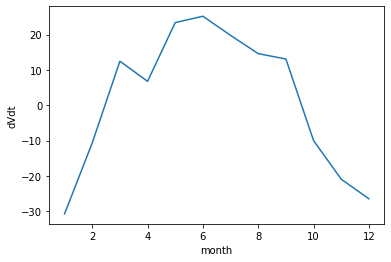

In [91]:
dVdt_clim_bot.plot()

### $\Psi$

In [92]:
#remember we are switching signs!
psi_clim_bot = - psi_vel_clim.isel(sigma2_bin=-1) + psi_vel_clim.sel(sigma2_bin=1037.195, method='nearest')
psi_clim_bot.load()

<xarray.DataArray 'psi_vel' (month: 12)>
array([-3.8903146, -2.4768422, -1.7837069, -2.0678785, -3.4885893,
       -4.8606825, -3.9772308, -2.902129 , -2.3287213, -1.6370052,
       -0.6515557, -1.8787321], dtype=float32)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

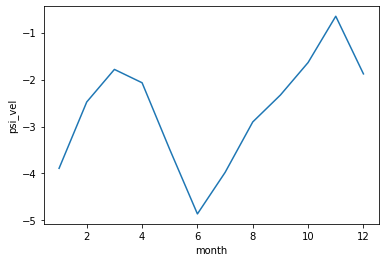

In [93]:
psi_clim_bot.plot();

### $\Omega$

In [94]:
omega_clim_bot = clim(omega_bdy)
omega_clim_bot.load()

<xarray.DataArray 'omega_trans' (month: 12)>
array([-26.88957079,  -8.21999408,  14.24289416,   8.82245348,
        26.88407294,  30.04833528,  23.74844692,  17.50457265,
        15.40163348,  -8.38294528, -20.29708249, -24.61958586])
Coordinates:
    sigma2_bin  float64 1.037e+03
  * month       (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

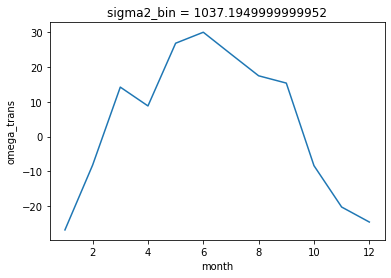

In [95]:
omega_clim_bot.plot();

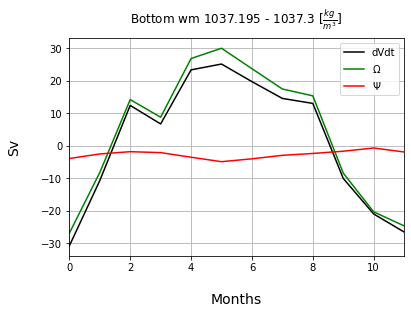

In [96]:
fig, ax1 = plt.subplots()
ax1.plot(dVdt_clim_bot, label='dVdt', color='k')
ax1.plot(omega_clim_bot, label=r'$\Omega$', color='green')
ax1.plot(psi_clim_bot, label=r'$\Psi$', color='red')
ax1.set_title(r'Bottom wm 1037.195 - 1037.3 [$\frac{kg}{m^3}$]', pad=15)
ax1.set_ylabel('Sv', fontsize=14, labelpad=20)
ax1.set_xlabel('Months', fontsize=14, labelpad=20)
ax1.set_xlim(0, 11)
plt.legend()
plt.grid();

In [97]:
- dVdt_clim_bot + psi_clim_bot + omega_clim_bot

<xarray.DataArray (month: 12)>
array([ 6.06264386e-07,  1.34346980e-07,  8.40341542e-07,  1.83133112e-07,
        1.00334485e-06, -5.87408095e-08,  9.37304019e-07,  1.76295419e-07,
       -1.27329342e-06,  2.84591188e-07, -1.97818306e-07, -2.71626885e-07])
Coordinates:
  * month       (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
    sigma2_bin  float64 1.037e+03

In [98]:
(- dVdt_clim_bot + psi_clim_bot + omega_clim_bot).mean('month')

<xarray.DataArray ()>
array(1.97011839e-07)
Coordinates:
    sigma2_bin  float64 1.037e+03

## Anomaly

## Bottom Anomaly

In [99]:
anom = anomaly(anom_ds)

In [149]:
anom.dVdt.time[799]

<xarray.DataArray 'time' ()>
array('2019-01-01T01:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2019-01-01T01:00:00
    month    int64 1

In [178]:
#with 1996 and earlier removed
year_start_index = [32, 105, 179, 252, 325, 398,
                    471, 544, 617, 690,
                    763]

In [151]:
import warnings
warnings.filterwarnings("ignore")

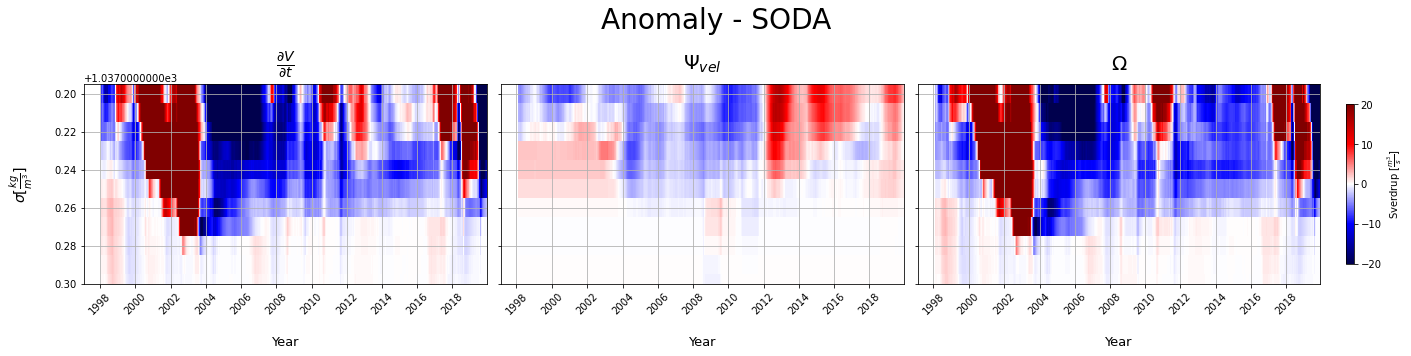

In [177]:
fig, (ax0,ax1,ax2) = plt.subplots(1, 3, figsize=(20, 5), sharey=True, gridspec_kw={'width_ratios': [2.4,2.4,3]})#, sharex=True)

#ax00 = ax0.twinx()
#ax10 = ax1.twinx()
#ax20 = ax2.twinx()

dVdt_anom_rolled = anom.dVdt/1e6
c = ax0.pcolormesh(dVdt_anom_rolled.time, 
                   dVdt_anom_rolled.sigma2_bin, 
                   dVdt_anom_rolled.T, vmin=-20, vmax=20, cmap='seismic')
#plt.colorbar(c, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax0)
ax0.set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14, labelpad=20)
#ax[0,0].set_xlabel('Time', fontsize=14)
ax0.set_title(r'$\frac{\partial V}{\partial t}$', fontsize=20, pad=15)
ax0.set_ylim(1037.3, 1037.195)
ax0.set_xticks(dVdt_anom_rolled.time.values[year_start_index])
ax0.set_xticklabels(ax0.get_xticks(), rotation = 45)
ax0.set_xticklabels([str(i) for i in np.arange(1998, 2020, 2)], rotation = 45)
ax0.set_xlabel('Year', fontsize=13, labelpad=20)
#ax00.plot(sam.time.isel(index=slice(49, 54)), sam.ANN.isel(index=slice(49, 54)))
#ax00.plot(dVdt_anom_rolled.time.values[year_start_index], sam.ANN.isel(index=slice(50, 55)))
ax0.grid()

psi_vel_anom_rolled = anom.psi_vel
c_psi = ax1.pcolormesh(psi_vel_anom_rolled.time, psi_vel_anom_rolled.sigma2_bin, psi_vel_anom_rolled.T,
                        vmin=-20, vmax=20, cmap='seismic')
#plt.colorbar(c_psi, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}$]', ax=ax1)
#ax[1,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[1,1].set_xlabel('Time', fontsize=14)
ax1.set_title(r'$\Psi_{vel}$', fontsize=20, pad=15)
#ax1.set_ylim(1037.3, 1036.5)
ax1.set_xticks(psi_vel_anom_rolled.time.values[year_start_index])
ax1.set_xticklabels([str(i) for i in np.arange(1998, 2020, 2)], rotation = 45)
ax1.set_xlabel('Year', fontsize=13, labelpad=20)
#ax10.plot(dVdt_anom_rolled.time.values[year_start_index], sam.ANN.isel(index=slice(50, 55)))
ax1.grid()

omega_anom_rolled = anom.omega_trans
c_omega = ax2.pcolormesh(omega_anom_rolled.time, omega_anom_rolled.sigma2_bin, omega_anom_rolled.T,
                        vmin=-20, vmax=20, cmap='seismic')
plt.colorbar(c_omega, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax2)
#ax[0,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[0,1].set_xlabel('Time', fontsize=14)
ax2.set_title(r'$\Omega$', fontsize=20, pad=15)
#ax2.set_ylim(1037.3, 1036.5)
ax2.set_xticks(omega_anom_rolled.time.values[year_start_index])
ax2.set_xticklabels([str(i) for i in np.arange(1998, 2020, 2)], rotation = 45)
ax2.set_xlabel('Year', fontsize=13, labelpad=20)
#ax20.plot(dVdt_anom_rolled.time.values[year_start_index], sam.ANN.isel(index=slice(50, 55)))
ax2.grid()

plt.suptitle('Anomaly - SODA', fontsize=28)
plt.tight_layout();

### $\frac{\partial V}{\partial t}$

In [179]:
#remember we're switching signs!
dVdt_anom_bot = - anom.dVdt.isel(sigma2_bin=-1) + anom.dVdt.sel(sigma2_bin=1037.195, method='nearest')
dVdt_anom_bot.load()

<xarray.DataArray 'dVdt' (time: 835)>
array([            nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan, -8.04629978e+06,
       -7.27112314e+06, -6.46049044e+06, -6.40219990e+06, -6.98340999e+06,
       -9.20112817e+06, -1.23368928e+07, -1.37952698e+07, -1.48924320e+07,
       -1.52005009e+07, -1.53768726e+07, -1.45331296e+07, -1.44217671e+07,
       -1.49124634e+07, -1.03421214e+07, -1.04098246e+07, -1.05740934e+07,
       -1.04334541e+07, -9.42712117e+06, -9.41130121e+06, -8.65687016e+06,
       -7.80444915e+06, -7.75598560e+06, -7.87516936e+06, -8.90870897e+06,
       -8.71828497e+06, -8.26155219e+06, -8.28416719e+06, -4.33597854e+06,
        2.28856593e+05,  5.94812922e+06,  8.57846222e+06,  9.58800871e+06,
        1.00269632e+07,  1.12122082e+07,  1.26528523e+07,  1.33664143e+07,
        1.30124160e+07,  1.11878542e+07,  1.15484025e+07,  1.33488385e+07,
        1.45015507e+07,  1.52697783e+07,  1.57123511e+07,  1.36290081e+07,
...
        4.56690431e+07,  4.46247124e+07,  4.30922997e+07,  4.19393228e+07,
        4.10284539e+07,  4.08962562e+07,  1.62099125e+07,  1.50040702e+07,
        1.59051488e+07,  1.64074130e+07,  1.66030214e+07,  1.60427786e+07,
        1.41144900e+07,  1.21428222e+07,  8.35963566e+06,  9.10678040e+06,
        5.90517393e+06,  7.39961908e+05, -1.75203362e+06, -3.78444063e+06,
       -3.94517735e+06,  1.46148128e+06,  8.80685624e+06,  1.42577735e+07,
        1.77506892e+07,  2.28783445e+07,  3.24397982e+07,  3.58509453e+07,
        3.62086616e+07,  3.69330256e+07,  3.71238873e+07,  3.73841918e+07,
        3.63007341e+07,  3.51559741e+07,  3.56351652e+07,  3.55882277e+07,
        3.40324361e+07,  3.21946413e+07,  2.82535770e+07,  2.14617590e+07,
        1.87298542e+07,  1.70348775e+07,  4.03349817e+07,  3.06562979e+07,
        2.02503417e+07,  1.87778950e+07,  1.73393089e+07,  1.60209176e+07,
        1.53741834e+07,  1.09947889e+07,  7.54761155e+06,  2.64312612e+06,
       -4.00403141e+05,  7.80102587e+05, -6.83882166e+05, -4.02123017e+06,
       -7.71844938e+06, -1.61001827e+07, -2.56298373e+07, -3.27797040e+07,
       -3.76144254e+07, -4.32027321e+07, -5.32237156e+07, -5.66076900e+07,
       -5.76570000e+07, -5.90285769e+07, -6.01705447e+07, -6.07838255e+07,
       -6.00459781e+07, -5.86824742e+07, -5.86368960e+07, -5.82476287e+07,
       -5.69844611e+07, -5.92774366e+07, -5.85767810e+07, -5.31485886e+07,
       -5.07799722e+07, -4.92290925e+07, -4.64816566e+07])
Coordinates:
  * time     (time) datetime64[ns] 1997-02-15T01:00:00 ... 2019-12-17T01:00:00
    month    (time) int64 2 2 3 3 3 4 4 4 5 5 5 ... 9 9 10 10 10 11 11 11 12 12

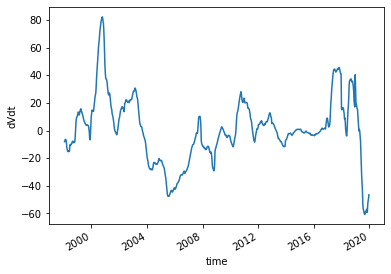

In [180]:
(dVdt_anom_bot/1e6).plot();

### $\Psi$

In [181]:
#remember we're switching signs!
psi_anom_bot = - anom.psi_vel.isel(sigma2_bin=-1) + anom.psi_vel.sel(sigma2_bin=1037.195, method='nearest')
psi_anom_bot.load()

<xarray.DataArray 'psi_vel' (time: 835)>
array([            nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan, -4.14328146e+00,
       -4.23577452e+00, -4.22469425e+00, -4.39161158e+00, -4.42894650e+00,
       -4.72644520e+00, -4.62794590e+00, -4.33659601e+00, -4.12817717e+00,
       -4.03062439e+00, -3.66005373e+00, -3.47235203e+00, -3.26366401e+00,
       -2.98379326e+00, -2.96318150e+00, -2.77250671e+00, -2.58132529e+00,
       -2.42048621e+00, -2.39325023e+00, -2.43706012e+00, -2.36888838e+00,
       -2.16156816e+00, -2.18633962e+00, -2.14151764e+00, -1.82979798e+00,
       -1.44859481e+00, -1.20113814e+00, -9.98034596e-01, -9.72178161e-01,
       -9.97725070e-01, -9.25773859e-01, -6.37083411e-01, -4.63263243e-01,
       -2.40584642e-01, -2.83181071e-01, -1.32508144e-01, -1.74374297e-01,
       -4.45635110e-01, -8.62526476e-01, -1.26800704e+00, -1.50177407e+00,
       -1.34956431e+00, -1.51986313e+00, -1.84816146e+00, -2.25118685e+00,
...
        1.36567295e+00,  1.34420013e+00,  1.27948368e+00,  1.27173460e+00,
        1.23724663e+00,  1.40192890e+00,  1.30814362e+00,  1.27200186e+00,
        1.24485195e+00,  1.13526535e+00,  9.88659739e-01,  9.35265779e-01,
        8.64766061e-01,  9.75883484e-01,  1.00997245e+00,  9.93720591e-01,
        9.76004183e-01,  9.80604947e-01,  1.09577107e+00,  1.21460640e+00,
        1.23915887e+00,  1.10625243e+00,  1.10365760e+00,  9.75394487e-01,
        7.56743729e-01,  8.65926623e-01,  1.27464783e+00,  1.47596538e+00,
        1.66748154e+00,  1.55293047e+00,  1.74989867e+00,  2.21898866e+00,
        2.55722666e+00,  2.59621549e+00,  2.84983182e+00,  3.05061126e+00,
        3.72764206e+00,  4.18773127e+00,  4.73160362e+00,  5.28708982e+00,
        5.80868196e+00,  5.88965940e+00,  6.11604595e+00,  6.40902042e+00,
        6.70047951e+00,  7.08994150e+00,  7.38207436e+00,  7.56167173e+00,
        7.68053198e+00,  7.77801752e+00,  7.90402985e+00,  7.71418095e+00,
        7.90027857e+00,  7.92554808e+00,  7.94549417e+00,  7.93709898e+00,
        8.00553513e+00,  8.16983700e+00,  8.26869965e+00,  8.35698128e+00,
        8.43783092e+00,  8.39046574e+00,  8.04257679e+00,  7.74893856e+00,
        7.51703644e+00,  7.48408413e+00,  7.13256598e+00,  6.50437784e+00,
        6.01762867e+00,  5.92549372e+00,  5.75489044e+00,  5.55871964e+00,
        5.01480007e+00,  4.47367525e+00,  4.07085133e+00,  3.46180820e+00,
        2.90171933e+00,  2.75556016e+00,  2.57084703e+00], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1997-02-15T01:00:00 ... 2019-12-17T01:00:00
    month    (time) int64 2 2 3 3 3 4 4 4 5 5 5 ... 9 9 10 10 10 11 11 11 12 12

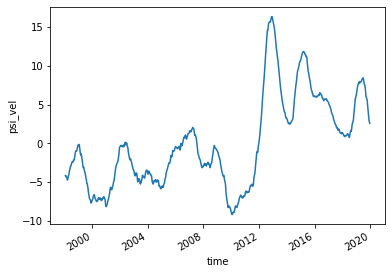

In [182]:
psi_anom_bot.plot();

### $\Omega$

In [183]:
omega_anom_bot = anomaly(omega_bdy)
omega_anom_bot.load()

<xarray.DataArray 'omega_trans' (time: 835)>
array([            nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan, -3.90301909e+00,
       -3.03534930e+00, -2.23579684e+00, -2.01058913e+00, -2.55446413e+00,
       -4.47468366e+00, -7.70894748e+00, -9.45867396e+00, -1.07642552e+01,
       -1.11698772e+01, -1.17168195e+01, -1.10607783e+01, -1.11581038e+01,
       -1.19286708e+01, -7.37894064e+00, -7.63731849e+00, -7.99276871e+00,
       -8.01296849e+00, -7.03387175e+00, -6.97424188e+00, -6.28798239e+00,
       -5.64288181e+00, -5.56964685e+00, -5.73365249e+00, -7.07891182e+00,
       -7.26969092e+00, -7.06041486e+00, -7.28613339e+00, -3.36380116e+00,
        1.22658092e+00,  6.87390229e+00,  9.21554487e+00,  1.00512712e+01,
        1.02675471e+01,  1.14953886e+01,  1.27853597e+01,  1.35407879e+01,
        1.34580504e+01,  1.20503799e+01,  1.28164088e+01,  1.48506117e+01,
        1.58511142e+01,  1.67896405e+01,  1.75605117e+01,  1.58801939e+01,
...
        4.43033739e+01,  4.32805161e+01,  4.18128199e+01,  4.06675921e+01,
        3.97912112e+01,  3.94943311e+01,  1.49017728e+01,  1.37320724e+01,
        1.46603008e+01,  1.52721515e+01,  1.56143656e+01,  1.51075167e+01,
        1.32497279e+01,  1.11669426e+01,  7.34966708e+00,  8.11306374e+00,
        4.92917363e+00, -2.40639124e-01, -2.84780074e+00, -4.99904307e+00,
       -5.18433220e+00,  3.55232825e-01,  7.70320260e+00,  1.32823830e+01,
        1.69939493e+01,  2.20124218e+01,  3.11651543e+01,  3.43749838e+01,
        3.45411839e+01,  3.53800989e+01,  3.53739925e+01,  3.51652069e+01,
        3.37435113e+01,  3.25597627e+01,  3.27853374e+01,  3.25376205e+01,
        3.03047979e+01,  2.80069140e+01,  2.35219775e+01,  1.61746732e+01,
        1.29211762e+01,  1.11452220e+01,  3.42189398e+01,  2.42472819e+01,
        1.35498669e+01,  1.16879580e+01,  9.95723902e+00,  8.45925026e+00,
        7.69365570e+00,  3.21677497e+00, -3.56414247e-01, -5.07105053e+00,
       -8.30067767e+00, -7.14544143e+00, -8.62937177e+00, -1.19583247e+01,
       -1.57239797e+01, -2.42700153e+01, -3.38985324e+01, -4.11366805e+01,
       -4.60522512e+01, -5.15931929e+01, -6.12662868e+01, -6.43566239e+01,
       -6.51740316e+01, -6.65126561e+01, -6.73031054e+01, -6.72881978e+01,
       -6.60636017e+01, -6.46079628e+01, -6.43917816e+01, -6.38063436e+01,
       -6.19992563e+01, -6.37511070e+01, -6.26476274e+01, -5.66103918e+01,
       -5.36816868e+01, -5.19846477e+01, -4.90524987e+01])
Coordinates:
    sigma2_bin  float64 1.037e+03
  * time        (time) datetime64[ns] 1997-02-15T01:00:00 ... 2019-12-17T01:0...
    month       (time) int64 2 2 3 3 3 4 4 4 5 5 ... 9 9 10 10 10 11 11 11 12 12

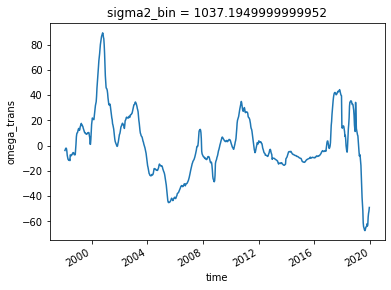

In [184]:
omega_anom_bot.plot();

In [55]:
omega_anom_bot.time

<xarray.DataArray 'time' (time: 985)>
array(['1993-01-07T01:00:00.000000000', '1993-01-17T01:00:00.000000000',
       '1993-01-27T01:00:00.000000000', ..., '2019-11-27T01:00:00.000000000',
       '2019-12-07T01:00:00.000000000', '2019-12-17T01:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    sigma2_bin  float64 1.037e+03
  * time        (time) datetime64[ns] 1993-01-07T01:00:00 ... 2019-12-17T01:0...
    month       (time) int64 1 1 1 2 2 2 3 3 3 4 ... 9 9 10 10 10 11 11 11 12 12

In [186]:
anom.time[32]

<xarray.DataArray 'time' ()>
array('1998-01-01T01:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 1998-01-01T01:00:00
    month    int64 1

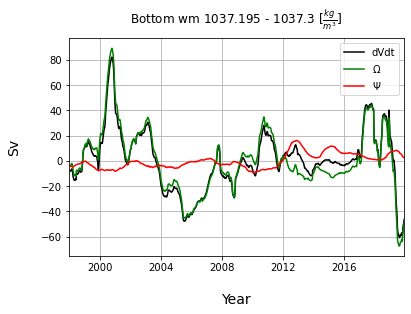

In [187]:
fig, ax1 = plt.subplots()

ax1.plot(anom.time, dVdt_anom_bot/1e6, label='dVdt', color='k')
ax1.plot(anom.time, omega_anom_bot, label=r'$\Omega$', color='green')
ax1.plot(anom.time, psi_anom_bot, label=r'$\Psi$', color='red')
ax1.set_title(r'Bottom wm 1037.195 - 1037.3 [$\frac{kg}{m^3}$]', pad=15)
ax1.set_ylabel('Sv', fontsize=14, labelpad=20)
ax1.set_xlabel('Year', fontsize=14, labelpad=20)
ax1.set_xlim(anom.time[32], anom.time[-1]) #1994-2019
ax1.grid()
ax1.legend();

## Indices

In [188]:
soda = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SODA/datasets/soda_si_index.zarr'))
sam = xr.open_dataarray('/home/jovyan/WMT-project/Climate-Indices/SAM-index/sam_index')
enso = xr.open_dataarray('/home/jovyan/WMT-project/Climate-Indices/ENSO-index/oni')

In [189]:
soda.time

<xarray.DataArray 'time' (time: 2117)>
array([cftime.DatetimeJulian(1992, 1, 5, 13, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(1992, 1, 10, 13, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(1992, 1, 15, 13, 0, 0, 0, has_year_zero=False),
       ...,
       cftime.DatetimeJulian(2020, 12, 13, 13, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(2020, 12, 18, 13, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(2020, 12, 23, 13, 0, 0, 0, has_year_zero=False)],
      dtype=object)
Coordinates:
    month    (time) int64 dask.array<chunksize=(2117,), meta=np.ndarray>
  * time     (time) object 1992-01-05 13:00:00 ... 2020-12-23 13:00:00
Attributes:
    bounds:          time_bounds
    calendar_type:   JULIAN
    cartesian_axis:  T
    long_name:       time

In [190]:
soda_monthly = soda.resample(time='MS').mean()
enso_soda_time = enso.sel(time=slice('1992','2020'))
sam_soda_time = sam.sel(time=slice('1992','2020')).assign_coords(coords={'time':enso_soda_time.time})

In [191]:
soda_monthly['time'] = soda_monthly.indexes['time'].to_datetimeindex()

In [192]:
indices = xr.merge([soda_monthly.soda_si_index.rename('soda'), 
                    enso_soda_time.drop('month').rename('enso'), 
                    sam_soda_time.drop('month').rename('sam')])

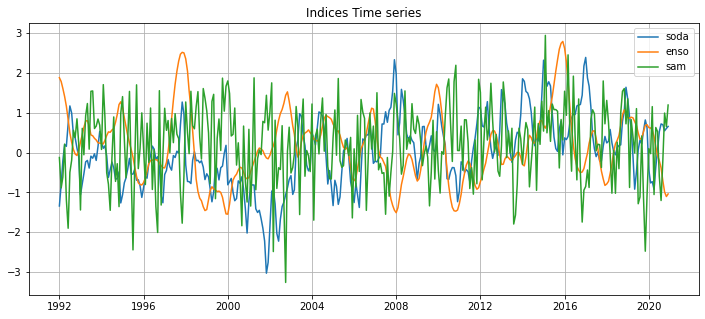

In [193]:
fig, ax = plt.subplots(figsize=(12,5))
for i in indices.variables:
    if i =='time':
        continue
    ax.plot(indices.time, indices[i], label=f'{indices[i].name}')
    
plt.legend()
plt.grid()
plt.title('Indices Time series');

## Heat map of Corralation matrices

In [194]:
import seaborn as sn

In [197]:
dVdt_anom_bot.time

<xarray.DataArray 'time' (time: 835)>
array(['1997-02-15T01:00:00.000000000', '1997-02-25T01:00:00.000000000',
       '1997-03-07T01:00:00.000000000', ..., '2019-11-27T01:00:00.000000000',
       '2019-12-07T01:00:00.000000000', '2019-12-17T01:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1997-02-15T01:00:00 ... 2019-12-17T01:00:00
    month    (time) int64 2 2 3 3 3 4 4 4 5 5 5 ... 9 9 10 10 10 11 11 11 12 12

In [200]:
#to match new anom ds 1997-2020
indices_sliced = indices.sel(time=slice('1997-02', '2020'))
indices_sliced

<xarray.Dataset>
Dimensions:  (time: 287)
Coordinates:
  * time     (time) datetime64[ns] 1997-02-01 1997-03-01 ... 2020-12-01
Data variables:
    soda     (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    enso     (time) float32 -0.2451 0.02289 0.3977 ... -0.9883 -1.102 -1.037
    sam      (time) float64 0.5607 0.808 8.659e-05 ... 0.9945 0.6537 1.197

In [201]:
indices_df = indices_sliced.to_dataframe()
indices_df.head()

,soda,enso,sam
time,,,
1997-02-01,-0.446163,-0.245119,0.560671
1997-03-01,-0.171458,0.022890,0.807973
1997-04-01,-0.355403,0.397670,0.000087
1997-05-01,-0.439283,0.863279,0.857589
1997-06-01,-0.072488,1.320337,0.251285


In [203]:
dVdt_anom_bot.time[32]

<xarray.DataArray 'time' ()>
array('1998-01-01T01:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 1998-01-01T01:00:00
    month    int64 1

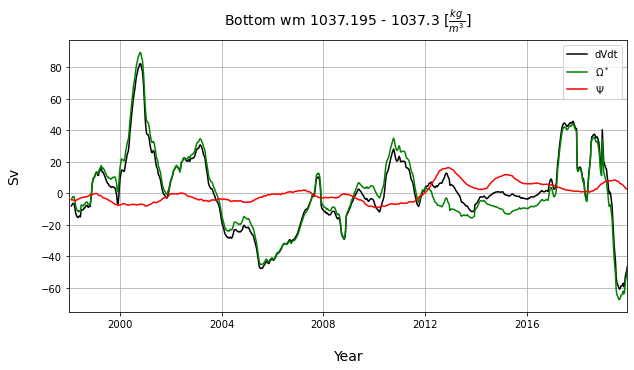

In [204]:
fig = plt.subplots(figsize=(10,5))
plt.plot(dVdt_anom_bot.time, dVdt_anom_bot/1e6, label='dVdt', color='k')
plt.plot(omega_anom_bot.time, omega_anom_bot, label=r'$\Omega^*$', color='green')
plt.plot(psi_anom_bot.time, psi_anom_bot, label=r'$\Psi$', color='red')
plt.title(r'Bottom wm 1037.195 - 1037.3 [$\frac{kg}{m^3}$]', fontsize=14, pad=15)
plt.ylabel('Sv', fontsize=14, labelpad=20)
plt.xlabel('Year', fontsize=14, labelpad=20)
plt.xlim(dVdt_anom_bot.time[32], dVdt_anom_bot.time[-1])

plt.legend()
plt.grid();

In [205]:
ds_unresampled = xr.merge([dVdt_anom_bot.rename('dvdt'), 
                           psi_anom_bot.rename('psi'), 
                           omega_anom_bot.rename('omega')]).drop(['month','sigma2_bin'])
ds = ds_unresampled.resample(time='MS').mean()

In [206]:
ds.coords

Coordinates:
  * time     (time) datetime64[ns] 1997-02-01 1997-03-01 ... 2019-12-01

In [208]:
indices_sliced.coords

Coordinates:
  * time     (time) datetime64[ns] 1997-02-01 1997-03-01 ... 2020-12-01

In [209]:
budget_df = ds.to_dataframe()

In [210]:
budget_df.tail()

,dvdt,psi,omega
time,,,
2019-08-01,-5.999432e+07,7.040342,-67.034653
2019-09-01,-5.912178e+07,5.899338,-65.021115
2019-10-01,-5.816984e+07,5.015732,-63.185569
2019-11-01,-5.416845e+07,3.478126,-57.646569
2019-12-01,-4.785537e+07,2.663204,-50.518573


### Correlation matrix of all terms (budget & indices)

In [211]:
import pandas as pd

In [212]:
budget_ind = pd.concat([budget_df, indices_df], axis=1)
budget_ind.tail()

,dvdt,psi,omega,soda,enso,sam
time,,,,,,
2020-08-01,NaN,NaN,NaN,0.721856,-0.383115,-1.201919
2020-09-01,NaN,NaN,NaN,0.702181,-0.710986,-0.175974
2020-10-01,NaN,NaN,NaN,0.549043,-0.988256,0.994549
2020-11-01,NaN,NaN,NaN,0.608854,-1.101873,0.653681
2020-12-01,NaN,NaN,NaN,0.659053,-1.036802,1.196730


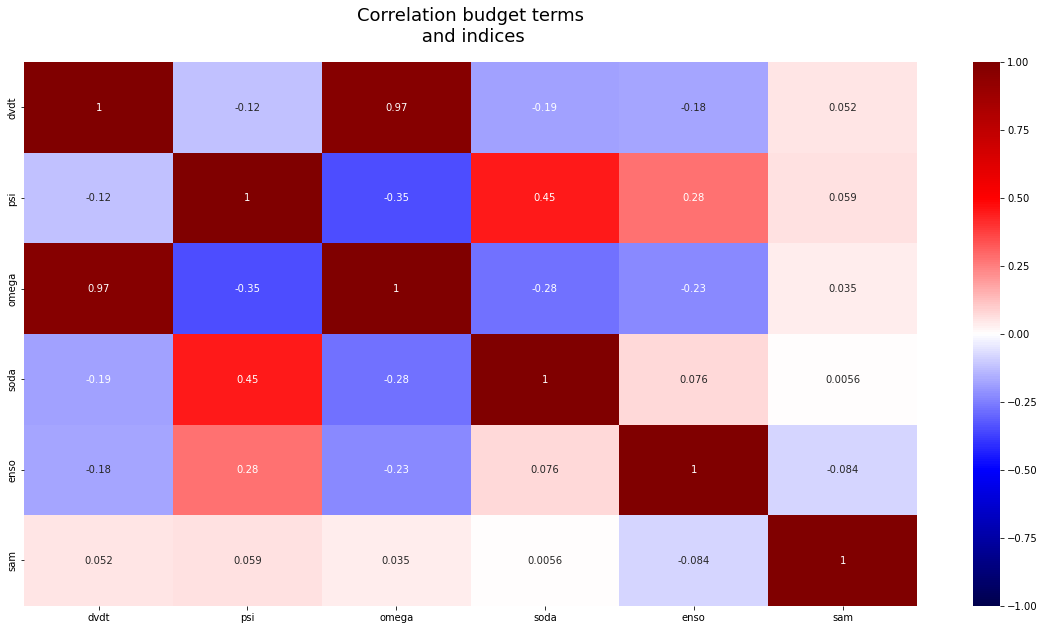

In [213]:
plt.figure(figsize=(20,10))
sn.heatmap(budget_ind.corr(), annot=True, cmap='seismic', vmin=-1, vmax=1)
plt.title('Correlation budget terms\n and indices', fontsize=18, pad=20.5);

In [214]:
corr = budget_ind.corr()
corr

,dvdt,psi,omega,soda,enso,sam
dvdt,1.000000,-0.118190,0.972394,-0.185393,-0.175301,0.051816
psi,-0.118190,1.000000,-0.346638,0.448088,0.277924,0.059293
omega,0.972394,-0.346638,1.000000,-0.280423,-0.230903,0.035012
soda,-0.185393,0.448088,-0.280423,1.000000,0.075641,0.005624
enso,-0.175301,0.277924,-0.230903,0.075641,1.000000,-0.083650
sam,0.051816,0.059293,0.035012,0.005624,-0.083650,1.000000


In [215]:
dvdt_psi = corr.iloc[0, 1]
dvdt_omega = corr.iloc[0, 2]
psi_omega = corr.iloc[2, 1]

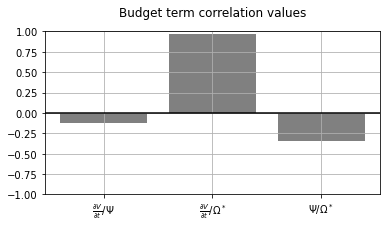

In [218]:
fig, ax0 = plt.subplots(1,1, figsize=(6,3))

ax0.bar(x=r'$\frac{\partial V}{\partial t}/\Psi$', height = dvdt_psi, color='grey')
ax0.bar(x=r'$\frac{\partial V}{\partial t}/\Omega^*$', height = dvdt_omega, color='grey')
ax0.bar(x=r'$\Psi/\Omega^*$', height= psi_omega, color='grey')
ax0.axhline(y=0, color='k')
ax0.set_title(r'Budget term correlation values', fontsize=12, pad=15)
ax0.set_ylabel('')
ax0.grid()
ax0.set_ylim(-1,1);